In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [5]:
# Assume the dataset is loaded in a DataFrame named `data`
data = pd.read_csv('adult.csv')

# Handle missing values if any
data = data.replace('?', np.nan)
data = data.dropna()

# Use a smaller subset of the data for quicker computation (optional)
subset_data = data.sample(frac=0.2, random_state=42)

# Define feature columns and target
features = subset_data.drop(columns=['income'])
target = subset_data['income']

# Encode target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Preprocess data
# Encode categorical variables and standardize numerical features
categorical_features = features.select_dtypes(include=['object']).columns
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)



In [3]:
# Define the model
model = RandomForestClassifier(n_estimators=50, random_state=42)

# Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Perform k-fold cross-validation with fewer folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, features, target, cv=kf)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')

Cross-Validation Scores: [0.85572139 0.84798231 0.83250415 0.85903814 0.84789823]
Mean CV Score: 0.8486288444698825


In [7]:
# Create a pipeline with preprocessing and gradient boosting classifier
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train and evaluate the model with varying numbers of estimators and learning rates
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {grid_search.best_score_}')


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best CV Score: 0.8657912923289566


In [9]:
# Define the random forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the random forest classifier
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_pipeline.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.7752161383285303
Recall: 0.5886214442013129
F1-Score: 0.6691542288557214


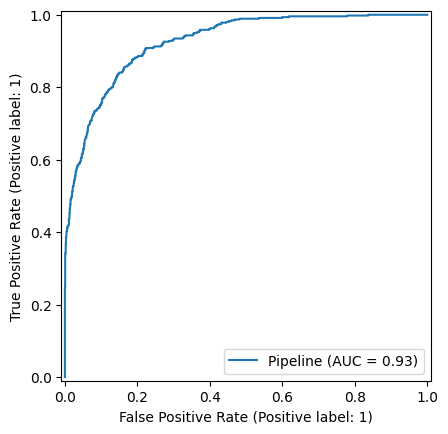

ROC AUC: 0.9257393212745848


In [13]:
# Define the gradient boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

# Train the gradient boosting classifier
gb_pipeline.fit(X_train, y_train)

# Plot ROC curve and compute AUC
RocCurveDisplay.from_estimator(gb_pipeline, X_test, y_test)
plt.show()

# Compute AUC
y_pred_proba = gb_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc}')


In [14]:
from sklearn.svm import SVC

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Evaluate each classifier
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = auc(*roc_curve(y_test, y_pred_proba)[:2])
    
    print(f'{name} - Accuracy: {scores.mean()}')
    print(f'{name} - Precision: {precision}')
    print(f'{name} - Recall: {recall}')
    print(f'{name} - F1-Score: {f1}')
    print(f'{name} - ROC AUC: {roc_auc}')


Random Forest - Accuracy: 0.84713199723566
Random Forest - Precision: 0.7752161383285303
Random Forest - Recall: 0.5886214442013129
Random Forest - F1-Score: 0.6691542288557214
Random Forest - ROC AUC: 0.9048277614491215
Gradient Boosting - Accuracy: 0.8648237733241189
Gradient Boosting - Precision: 0.8287461773700305
Gradient Boosting - Recall: 0.5929978118161926
Gradient Boosting - F1-Score: 0.6913265306122449
Gradient Boosting - ROC AUC: 0.9257393212745848
SVM - Accuracy: 0.8507256392536281
SVM - Precision: 0.8068535825545171
SVM - Recall: 0.5667396061269147
SVM - F1-Score: 0.6658097686375322
SVM - ROC AUC: 0.9077499255499593
